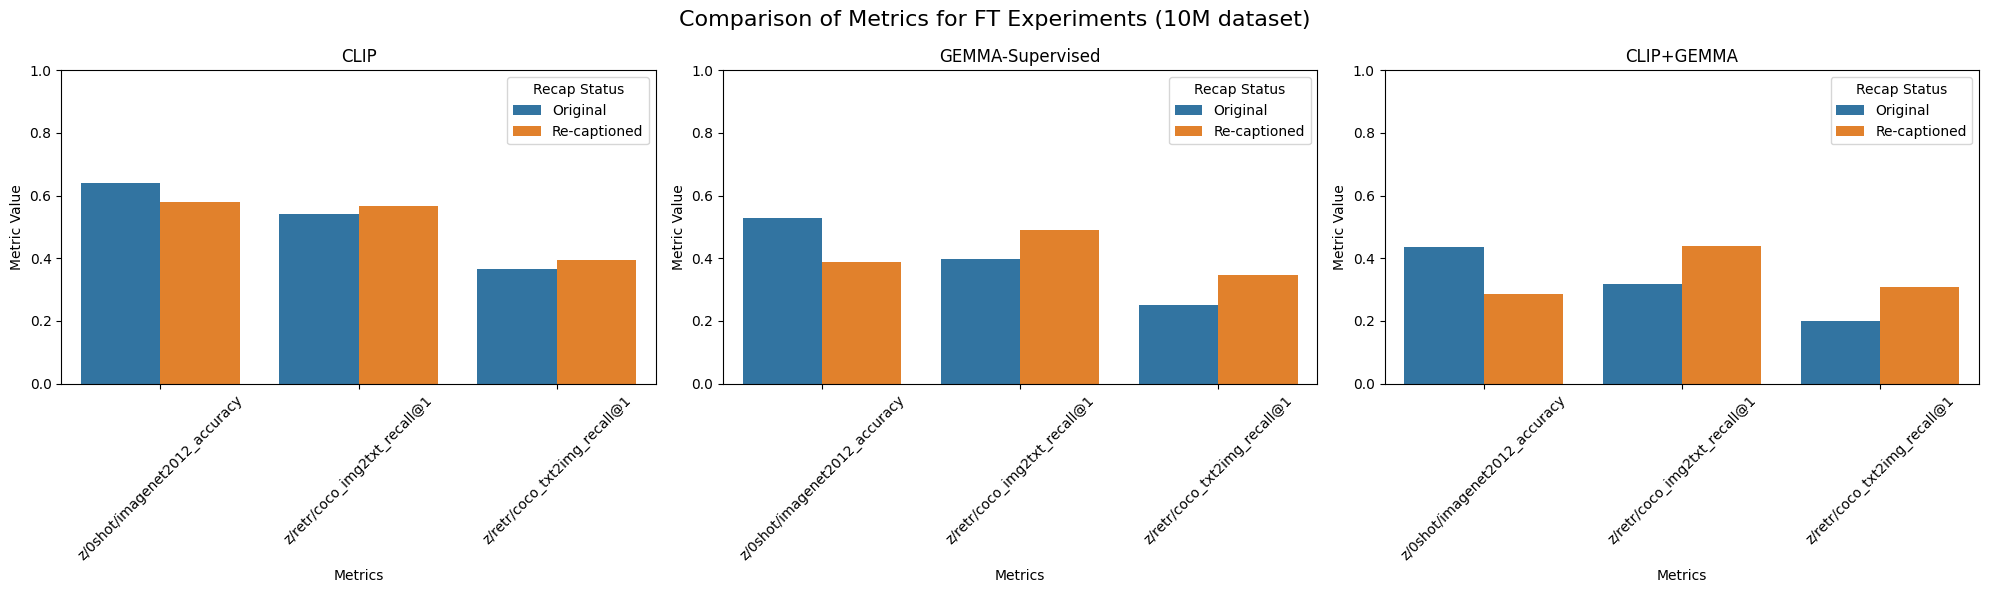

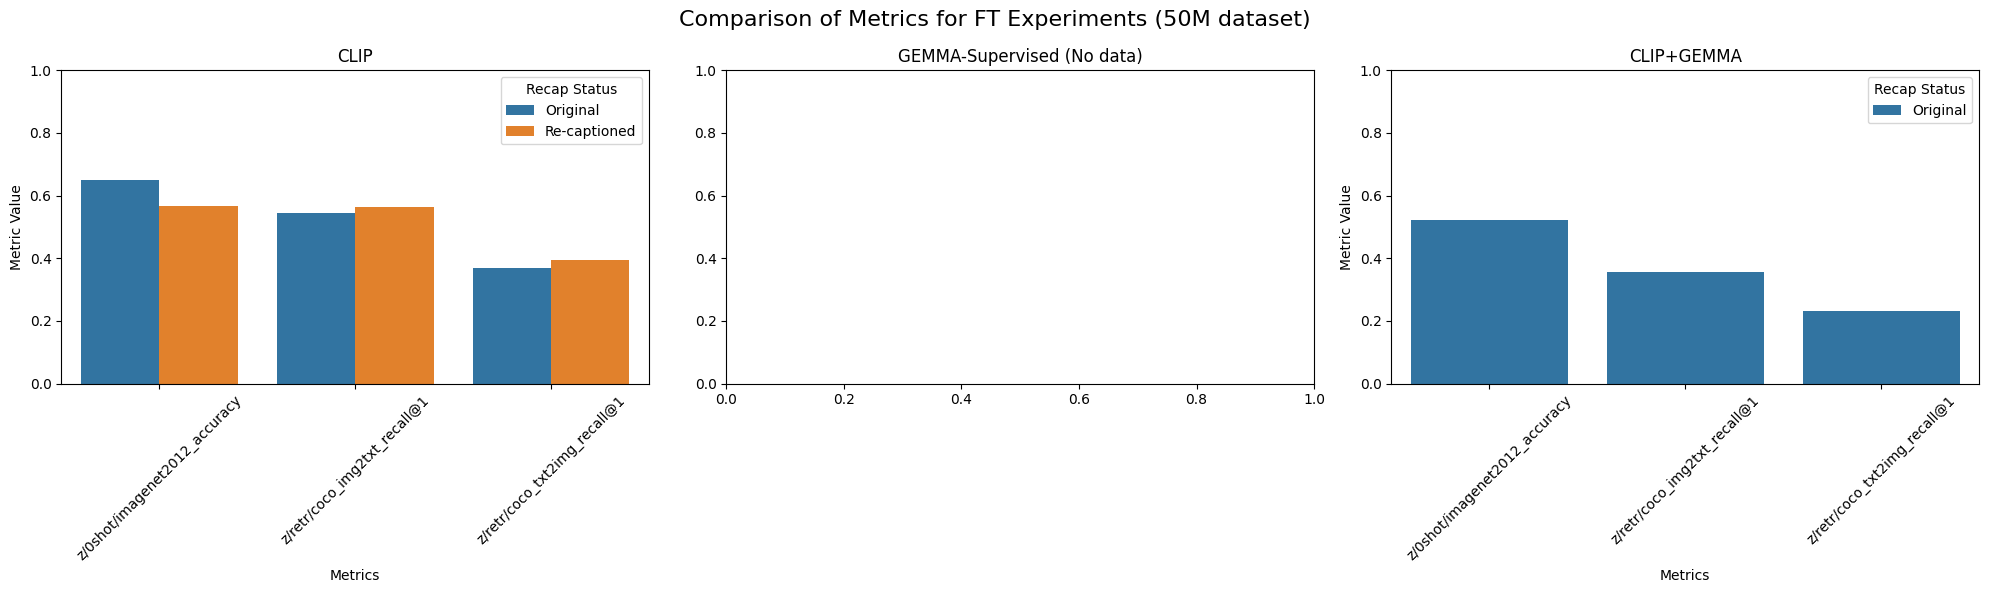


10M Dataset Results:

CLIP+GEMMA:
  z/0shot/imagenet2012_accuracy (Original): 0.4346
  z/0shot/imagenet2012_accuracy (Re-captioned): 0.2863
  z/retr/coco_img2txt_recall@1 (Original): 0.3166
  z/retr/coco_img2txt_recall@1 (Re-captioned): 0.4406
  z/retr/coco_txt2img_recall@1 (Original): 0.1987
  z/retr/coco_txt2img_recall@1 (Re-captioned): 0.3077

CLIP:
  z/0shot/imagenet2012_accuracy (Original): 0.6413
  z/0shot/imagenet2012_accuracy (Re-captioned): 0.5806
  z/retr/coco_img2txt_recall@1 (Original): 0.5420
  z/retr/coco_img2txt_recall@1 (Re-captioned): 0.5668
  z/retr/coco_txt2img_recall@1 (Original): 0.3657
  z/retr/coco_txt2img_recall@1 (Re-captioned): 0.3959

GEMMA-Supervised:
  z/0shot/imagenet2012_accuracy (Original): 0.5282
  z/0shot/imagenet2012_accuracy (Re-captioned): 0.3882
  z/retr/coco_img2txt_recall@1 (Original): 0.3972
  z/retr/coco_img2txt_recall@1 (Re-captioned): 0.4910
  z/retr/coco_txt2img_recall@1 (Original): 0.2501
  z/retr/coco_txt2img_recall@1 (Re-captioned): 0.34

In [15]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

datacomp_recap_10M = {
    "FT_clip+gemma_recapF": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k+gemma2b_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapFalse_10-03_0440",
    "FT_clip+gemma_recapT": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k+gemma2b_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapTrue_10-03_0440",
    "FT_clip_recapF": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapFalse_10-02_1912",
    "FT_clip_recapT": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapT_10-01_1442",
    "FT_gemma-supervised_recapF": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/gemma-supervised_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapFalse_10-02_1727",
    "FT_gemma-supervised_recapT": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/gemma-supervised_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapTrue_10-02_1437",
}

datacomp_recap_50M = {
    "FT_clip+gemma_50M_recapF": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k+gemma2b_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapFalse_50M_10-03_0440",
    "FT_clip_50M_recapF": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapFalse_50M_10-02_2028",
    "FT_clip_50M_recapT": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapTrue_50M_10-02_2028",
}

def get_final_metrics(experiment_name, experiments):
    ckpt_path = experiments[experiment_name]
    metrics_path = f'{ckpt_path}/big_vision_metrics.txt'

    final_metrics = {}
    with tf.io.gfile.GFile(metrics_path, 'r') as f:
        lines = f.read().split('\n')
        last_line = json.loads(lines[-2])  # Use -2 to avoid empty last line
        metrics_of_interest = [
            "z/0shot/imagenet2012_accuracy",
            "z/retr/coco_img2txt_recall@1",
            # "z/retr/coco_img2txt_recall@5",
            # "z/retr/coco_img2txt_recall@10",
            "z/retr/coco_txt2img_recall@1",
            # "z/retr/coco_txt2img_recall@5",
            # "z/retr/coco_txt2img_recall@10",
        ]
        for key in metrics_of_interest:
            if key in last_line:
                final_metrics[key] = last_line[key]
    return final_metrics

def prepare_plot_data(all_metrics, dataset_size):
    plot_data = []
    for exp, metrics in all_metrics.items():
        model_type = 'CLIP' if 'clip_recap' in exp or 'clip_50M' in exp else ('CLIP+GEMMA' if 'clip+gemma' in exp else 'GEMMA-Supervised')
        recap = 'Re-captioned' if 'recapT' in exp else 'Original'
        for metric, value in metrics.items():
            plot_data.append({
                'Model': model_type,
                'Recap': recap,
                'Metric': metric,
                'Value': value,
                'Dataset': f'{dataset_size}M'
            })
    return pd.DataFrame(plot_data)

def create_plots(df, dataset_size):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f'Comparison of Metrics for FT Experiments ({dataset_size}M dataset)', fontsize=16)

    for i, model in enumerate(['CLIP', 'GEMMA-Supervised', 'CLIP+GEMMA']):
        model_data = df[(df['Model'] == model) & (df['Dataset'] == f'{dataset_size}M')]
        
        if not model_data.empty:
            sns.barplot(x='Metric', y='Value', hue='Recap', data=model_data, ax=axes[i])
            
            axes[i].set_title(model)
            axes[i].set_xlabel('Metrics')
            axes[i].set_ylabel('Metric Value')
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].legend(title='Recap Status')
            axes[i].set_ylim(0, 1)
        else:
            axes[i].set_title(f"{model} (No data)")

    plt.tight_layout()
    plt.show()

# Collect and process data for both 10M and 50M experiments
all_metrics_10M = {exp: get_final_metrics(exp, datacomp_recap_10M) for exp in datacomp_recap_10M.keys()}
all_metrics_50M = {exp: get_final_metrics(exp, datacomp_recap_50M) for exp in datacomp_recap_50M.keys()}

df_10M = prepare_plot_data(all_metrics_10M, 10)
df_50M = prepare_plot_data(all_metrics_50M, 50)

# Create plots for 10M and 50M experiments
create_plots(df_10M, 10)
create_plots(df_50M, 50)

# Print the results
for dataset, df in [("10M", df_10M), ("50M", df_50M)]:
    print(f"\n{dataset} Dataset Results:")
    for model in df['Model'].unique():
        print(f"\n{model}:")
        for metric in df['Metric'].unique():
            for recap in df['Recap'].unique():
                values = df[(df['Model'] == model) & (df['Metric'] == metric) & (df['Recap'] == recap)]['Value']
                if not values.empty:
                    value = values.values[0]
                    print(f"  {metric} ({recap}): {value:.4f}")
                else:
                    print(f"  {metric} ({recap}): No data")